# Labellerr SDK & YOLOv8: An End-to-End Fine-Tuning Cookbook

### Purpose
This notebook provides a practical, step-by-step guide for building a complete object segmentation pipeline. We will use the [Labellerr Python SDK](https://github.com/tensormatics/SDKPython) to programmatically create a project and export annotated data, and then use that data to fine-tune a state-of-the-art [YOLOv8](https://github.com/ultralytics/ultralytics) model for a custom computer vision task.

### The Recipe: Banana Ripeness Segmentation
This specific recipe walks through the entire lifecycle of a machine learning project:
1.  **Environment Setup**: Installing all necessary libraries, including the Labellerr SDK and Ultralytics.
2.  **Data Acquisition**: Programmatically setting up [Kaggle](https://www.kaggle.com/) credentials to download our image dataset.
3.  **Project Creation & Export (via SDK)**: Using the Labellerr SDK to create a project, upload images, and export the polygon annotations in COCO JSON format.
4.  **Data Transformation**: Converting the exported Labellerr annotations into the specific `.txt` format required by YOLO.
5.  **Efficient Model Training**: Fine-tuning a pre-trained `yolov8n-seg.pt` model on our custom dataset using a resource-efficient approach (freezing the backbone).
6.  **Inference & Validation**: Using the newly trained model to run predictions on a sample image to verify its performance.

### Step 1: Install Dependencies and Set Up the Environment
This first step is crucial for preparing our Colab environment. We install all the Python packages required for the entire workflow.

-   **`labellerr_sdk`**: The official Python SDK to interact with the Labellerr platform API.
-   **`kaggle`**: The command-line interface to download datasets directly from Kaggle.
-   **`ultralytics`**: The library that provides the YOLOv8 model for training and inference.
-   **`Pillow`, `opencv-python`**: Essential libraries for image processing.
-   **`requests`**: Used for making HTTP requests, specifically to download our exported dataset file.
-   **`python-dotenv`**: A utility to manage environment variables (though we will define credentials directly in this notebook for simplicity).

In [ ]:
!python -m pip install --upgrade pip
!python -m pip install --quiet https://github.com/tensormatics/SDKPython/releases/download/prod/labellerr_sdk-1.0.0.tar.gz kaggle Pillow requests python-dotenv opencv-python numpy ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'labellerr_sdk' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'labellerr_sdk'. Discussion can be found at https://github.com/pypa/pip/issues/6334


### Step 2: Configure Kaggle API Access
To download our dataset without manual uploads, we need to authenticate with the Kaggle API. This cell securely writes your Kaggle username and API key to the `~/.kaggle/kaggle.json` file, which the Kaggle CLI automatically detects.

**Note**: Your credentials have been pre-filled in the code block below.

In [ ]:
import os, json, shutil
from pathlib import Path
from IPython.display import display, Markdown

# Get Kaggle credentials from user input
KAGGLE_USERNAME = input("Enter your Kaggle username: ")
KAGGLE_KEY = getpass("Enter your Kaggle API key: ")

# Create .kaggle directory in user's home folder
kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

# Write credentials to kaggle.json file
with open(kaggle_dir / "kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)

# Set proper permissions (600 = read/write for owner only)
os.chmod(kaggle_dir / "kaggle.json", 0o600)

display(Markdown("✅ Kaggle credentials configured at `~/.kaggle/kaggle.json`"))
display(Markdown("🔐 Credentials securely stored with proper file permissions"))

### Step 3: Download the Image Dataset
With our Kaggle credentials configured, we can now download the fruit ripeness dataset. We use the `!kaggle datasets download` command, specifying the dataset path and a local directory to store it. The `--unzip` flag conveniently extracts the files for us upon download.

- **Dataset**: [`leftin/fruit-ripeness-unripe-ripe-and-rotten`](https://www.kaggle.com/datasets/leftin/fruit-ripeness-unripe-ripe-and-rotten)
- **Destination**: The images will be saved in the `datasets/fruit_ripeness/` directory.

In [ ]:
from pathlib import Path
from IPython.display import display, Markdown

# Download dataset via Kaggle CLI (more reliable)
DATASET = "leftin/fruit-ripeness-unripe-ripe-and-rotten"
DATA_DIR = Path("datasets/fruit_ripeness")
DATA_DIR.mkdir(parents=True, exist_ok=True)

!kaggle datasets download -d {DATASET} -p {str(DATA_DIR)} --unzip

display(Markdown(f"✅ Downloaded dataset `{DATASET}` to `{DATA_DIR}`"))

Dataset URL: https://www.kaggle.com/datasets/leftin/fruit-ripeness-unripe-ripe-and-rotten
License(s): CC-BY-SA-4.0
 99% 3.60G/3.63G [00:30<00:00, 109MB/s] 
100% 3.63G/3.63G [00:30<00:00, 129MB/s]


✅ Downloaded dataset `leftin/fruit-ripeness-unripe-ripe-and-rotten` to `datasets/fruit_ripeness`

### Step 4: Prepare a Small Sample Dataset
Training on a full dataset can be time-consuming and unnecessary for this initial cookbook. This cell prepares a small, manageable subset of 20 random images.

The process is as follows:
1.  It scans the downloaded dataset directory for all valid image files (`.jpg`, `.png`, etc.).
2.  It randomly shuffles the list of images to ensure we get a diverse sample.
3.  It copies the first 20 images from the shuffled list into a new `sample_images/` directory.

This `sample_images/` directory is what we will upload to Labellerr.

In [ ]:
from pathlib import Path
from IPython.display import display, Markdown
import random
import shutil

# Prepare 10 sample images (ripe/unripe bananas subset if present; otherwise any images)
SEARCH_DIRS = [
    DATA_DIR,
]
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}

all_images = []
for base in SEARCH_DIRS:
    for p in base.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMAGE_EXTS:
            all_images.append(p)

random.shuffle(all_images)

SAMPLE_DIR = Path("sample_images")
SAMPLE_DIR.mkdir(exist_ok=True)

selected = all_images[:10]
for i, src in enumerate(selected, start=1):
    dst = SAMPLE_DIR / f"banana_{i:02d}{src.suffix.lower()}"
    shutil.copy2(src, dst)

display(Markdown(f"✅ Prepared {len(selected)} images in `{SAMPLE_DIR}`"))

✅ Prepared 10 images in `sample_images`

### Step 5: Initialize the Labellerr SDK Client
Now we'll connect to the Labellerr platform. This cell will prompt you for your Labellerr credentials to initialize the API client.

-   **Client ID**: Your workspace-specific ID.
-   **Email**: The email associated with your Labellerr account.
-   **API Key & Secret**: Found in your Labellerr account settings. These will be entered securely with hidden input.

In [ ]:
from getpass import getpass
from labellerr.client import LabellerrClient
from labellerr.exceptions import LabellerrError
from IPython.display import display, Markdown

# --- Interactive Input for Labellerr Credentials ---
print("Please enter your Labellerr API credentials.")
LABELLERR_CLIENT_ID = input("Labellerr Client ID: ")
LABELLERR_EMAIL = input("Labellerr Email: ")
LABELLERR_API_KEY = getpass("Labellerr API Key (input will be hidden): ")
LABELLERR_API_SECRET = getpass("Labellerr API Secret (input will be hidden): ")

# --- Initialize Labellerr Client ---
# This block attempts to initialize the client and provides clear feedback.
try:
    if not all([LABELLERR_API_KEY, LABELLERR_API_SECRET, LABELLERR_CLIENT_ID, LABELLERR_EMAIL]):
        raise ValueError("One or more required fields were left empty.")

    client = LabellerrClient(LABELLERR_API_KEY, LABELLERR_API_SECRET)

    display(Markdown("✅ Labellerr client initialized successfully!"))

except (LabellerrError, ValueError) as e:
    display(Markdown(f"❌ **Client Initialization Failed:** {e}"))
    client = None # Ensure client is not partially initialized

Please enter your Labellerr API credentials.
Labellerr Client ID: 14286
Labellerr Email: thenomadevel@gmail.com
Labellerr API Key (input will be hidden): ··········
Labellerr API Secret (input will be hidden): ··········


✅ Labellerr client initialized successfully!

### Step 6: Define the Annotation Project Configuration
This cell defines all the high-level parameters for the project we are about to create on Labellerr.

#### Annotation Guideline
The `ANNOTATION_QUESTIONS` list is the most critical part. It programmatically defines the annotation interface, instructing Labellerr to create:
- A **polygon** tool for an object class named `"Ripe Banana"`, which will be colored yellow (`#FFD700`).
- A second **polygon** tool for an object class named `"Unripe Banana"`, colored green (`#228B22`).
- Setting `required: False` makes the annotations optional, which is standard for object detection where an object may not be present in every image.

#### Project Details
The other variables (`PROJECT_NAME`, `DATASET_NAME`, etc.) define the metadata for the project and dataset that will appear in the Labellerr UI.

In [ ]:
# Define annotation questions: two polygon objects (Ripe, Unripe)
ANNOTATION_QUESTIONS = [
    {
        "question_number": 1,
        "question": "Ripe Banana",
        "question_id": "banana-ripe-polygon-001",
        "option_type": "polygon",
        "required": False,
        "options": [
            {"option_name": "#FFD700"}
        ],
        "question_metadata": []
    },
    {
        "question_number": 2,
        "question": "Unripe Banana",
        "question_id": "banana-unripe-polygon-002",
        "option_type": "polygon",
        "required": False,
        "options": [
            {"option_name": "#228B22"}
        ],
        "question_metadata": []
    }
]

PROJECT_NAME = "Fruit Ripeness (Ripe vs Unripe)"
DATASET_NAME = "fruit_ripeness_sample"
DATASET_DESCRIPTION = "10 images prepared from fruit ripeness dataset"
DATA_TYPE = "image"

### Step 7: Create the Annotation Guideline (Template)
Before creating the project itself, we must first define *how* the data will be annotated. In Labellerr, this is done by creating a reusable **Annotation Guideline** (also known as a template).

This cell uses the `create_annotation_guideline` SDK method, passing the `ANNOTATION_QUESTIONS` list we defined in the previous step. This tells Labellerr to set up an annotation interface with our specific "Ripe Banana" and "Unripe Banana" polygon tools.

The code captures the unique `template_id` from the API response, which is essential for linking these rules to our project in the next step.

In [ ]:
import json
from IPython.display import display, Markdown

template_id = None
try:
    res_str = client.create_annotation_guideline(
        LABELLERR_CLIENT_ID,
        ANNOTATION_QUESTIONS,
        template_name=f"{PROJECT_NAME} Template",
        data_type=DATA_TYPE,
    )

    # Handle case where SDK returns direct string ID instead of JSON
    if isinstance(res_str, str) and len(res_str) == 36 and res_str.count('-') == 4:
        template_id = res_str
        display(Markdown(f"✅ Template created: `{template_id}`"))
    else:
        # Try to parse as JSON if it's not a direct ID
        try:
            res = json.loads(res_str)
            template_id = res.get("response", {}).get("template_id")
            if template_id:
                display(Markdown(f"✅ Template created: `{template_id}`"))
            else:
                display(Markdown("⚠️ Could not find template_id in response"))
                display(Markdown(f"Raw response: `{res_str}`"))
        except json.JSONDecodeError as e:
            display(Markdown(f"⚠️ Response parsing issue: `{e}`"))
            display(Markdown(f"Raw response: `{res_str}`"))
            # If it looks like a UUID, use it directly
            if isinstance(res_str, str) and len(res_str) > 20:
                template_id = res_str
                display(Markdown(f"✅ Using response as template_id: `{template_id}`"))

except LabellerrError as e:
    display(Markdown(f"❌ Template creation failed: `{e}`"))

✅ Template created: `ce72ceb2-d4d1-4a08-9e95-0273be03e362`

### Step 8: Create the Project and Upload Images
This is the final step where all our configurations come together. The `initiate_create_project` method sends a complete payload to the Labellerr API to build the project from end to end.

The key parameters in the payload are:
-   `annotation_template_id`: This links the project to the specific annotation guideline we just created.
-   `project_name` & `dataset_name`: The metadata we defined earlier.
-   `folder_to_upload`: This crucial parameter points to our local `sample_images/` directory, instructing the SDK to automatically upload all 20 of our sample images into the newly created project.
-   `autolabel: False`: We specify `False` because we intend to perform manual annotation.

Upon successful execution, a new project will be visible in your Labellerr dashboard, fully configured and populated with our sample images, ready for annotation.

In [ ]:
import json
from pathlib import Path
from IPython.display import display, Markdown

project_id = None
if template_id:  # This should now be True
    try:
        payload = {
            'client_id': LABELLERR_CLIENT_ID,
            'dataset_name': DATASET_NAME,
            'dataset_description': DATASET_DESCRIPTION,
            'data_type': DATA_TYPE,
            'created_by': LABELLERR_EMAIL,
            'project_name': PROJECT_NAME,
            'annotation_template_id': template_id,  # Now has the real ID
            'rotation_config': {
                'annotation_rotation_count': 1,
                'review_rotation_count': 1,
                'client_review_rotation_count': 1
            },
            'autolabel': False,
            'folder_to_upload': str(Path('sample_images'))
        }
        res = client.initiate_create_project(payload)

        # Handle case where SDK returns direct string ID instead of JSON
        if isinstance(res, str) and len(res) == 36 and res.count('-') == 4:
            project_id = res
            display(Markdown(f"✅ Project created: `{project_id}`"))
        else:
            # Try to extract from JSON response
            try:
                if isinstance(res, str):
                    res_obj = json.loads(res)
                else:
                    res_obj = res
                project_id = res_obj.get('project_id', {}).get('response', {}).get('project_id')
                if project_id:
                    display(Markdown(f"✅ Project created: `{project_id}`"))
                else:
                    display(Markdown("⚠️ Could not find project_id in response"))
                    display(Markdown(f"Raw response: `{res}`"))
            except (json.JSONDecodeError, AttributeError) as e:
                display(Markdown(f"⚠️ Response parsing issue: `{e}`"))
                display(Markdown(f"Raw response: `{res}`"))
                # If it looks like a UUID, use it directly
                if isinstance(res, str) and len(res) > 20:
                    project_id = res
                    display(Markdown(f"✅ Using response as project_id: `{project_id}`"))

    except LabellerrError as e:
        display(Markdown(f"❌ Project creation failed: `{e}`"))

Rotation configuration validated . . .
Creating dataset . . .
Total file count: 10
Total file size: 1.2 MB
CPU count 2  Batch Count 1


Dataset created and ready for use


✅ Project created: `donelle_marginal_tyrannosaurus_87515`

### Step 9: Time to Annotate!
Your project is now live and ready on the Labellerr platform!

1.  **Log in** to your [Labellerr account](https://www.labellerr.com/).
2.  Navigate to your projects, and you will find the one named **"Fruit Ripeness (Ripe vs Unripe)"**.
3.  Open the project and begin annotating the 20 images by drawing polygons around the ripe and unripe bananas.

---

#### ✨ **Pro-Tip for Faster Labeling: Use SAM**
To dramatically speed up your segmentation task, Labellerr has integrated the **Segment Anything Model (SAM)** directly into the annotation interface. Instead of drawing complex polygons by hand, you can often just click on an object, and SAM will generate a precise mask for you.

You can learn more about how to leverage this powerful feature from their official blog:
- **[Labellerr AI Blog: SAM Articles](https://www.labellerr.com/blog/tag/sam/)**

---

Once you have finished annotating all the images, return to this notebook to proceed with the next steps: **exporting the data and training our model.**

![Image](https://github.com/user-attachments/assets/d55ab77f-5979-4a95-b10f-a9ca260060af)


### Step 10: Export Annotated Data and Download
Now that you've completed the annotation work in the Labellerr UI, it's time to retrieve your labeled data for model training. This cell performs a comprehensive export workflow:

**What this cell does:**
1. **Creates an Export Job**: Initiates a JSON export of all annotation statuses (`review`, `accepted`, etc.) from your project.
2. **Monitors Export Progress**: Implements a robust polling mechanism that checks the export status every 10 seconds for up to 5 minutes, ensuring the export completes successfully before attempting to download.
3. **Fetches Download URL**: Once the export is ready, retrieves a secure, time-limited download link from the Labellerr API.
4. **Downloads and Validates**: Downloads the JSON file locally and performs basic validation to confirm the data structure.

**Key Features:**
- **Robust Error Handling**: Handles various API response formats and potential network issues.
- **Progress Logging**: Provides detailed, timestamped logs for each step of the process.
- **Data Validation**: Automatically parses and displays a summary of the exported annotations.
- **Secure Download**: Uses the official Labellerr download API with proper authentication.

The exported JSON file will contain all your polygon annotations in Labellerr's format, ready for conversion to YOLO format in the next steps.

In [ ]:
# Export creation, status check, and DOWNLOAD with data validation
from IPython.display import display, Markdown
import requests
import json
import time
from pathlib import Path
import logging
import traceback
import uuid # Added import for uuid

# Configure Logger
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    force=True
)
logger = logging.getLogger(__name__)

# --- NEW: Global variable to store the downloaded annotations ---
downloaded_annotations = None

def create_export(client, project_id, client_id, export_config):
    """Initiates an export job on the Labellerr platform."""
    logger.info("Step 1: Creating export...")
    try:
        res = client.create_local_export(project_id, client_id, export_config)
        export_id = res["response"]["report_id"]
        logger.info(f"✅ Export created successfully. Export ID: {export_id}")
        return export_id
    except LabellerrError as e:
        logger.error(f"❌ Export creation failed: `{e}`")
        return None

def poll_export_status(client, api_key, api_secret, project_id, export_id, client_id, max_wait_time=300, wait_interval=10):
    """Polls Labellerr API for export completion status."""
    logger.info(f"Step 2: Polling for export completion (max {max_wait_time} seconds)...")
    elapsed_time = 0
    is_completed = False
    while elapsed_time < max_wait_time:
        raw_status = client.check_export_status(api_key=api_key, api_secret=api_secret, project_id=project_id, report_ids=[export_id], client_id=client_id)
        status_obj = None
        if isinstance(raw_status, dict): status_obj = raw_status
        elif isinstance(raw_status, str):
            try: status_obj = json.loads(raw_status)
            except json.JSONDecodeError: logger.warning(f"Could not parse status string: '{raw_status}'")

        if status_obj and status_obj.get('status') and len(status_obj['status']) > 0:
            export_status = status_obj['status'][0]
            is_completed = export_status.get('is_completed', False)
            export_status_text = export_status.get('export_status', 'Unknown')
            logger.info(f"Current status: '{export_status_text}' (Completed: {is_completed})")
            if is_completed:
                logger.info("✅ Export completed! Proceeding to download.")
                return True # Return True if completed
            elif export_status_text.lower() == "failed":
                logger.error("❌ Export failed!")
                return False # Return False if failed
        else:
            logger.warning(f"Unexpected status format or empty status. Raw response: {raw_status}")

        time.sleep(wait_interval)
        elapsed_time += wait_interval

    logger.warning(f"⏰ Export timeout after {max_wait_time} seconds.")
    return False # Return False if timed out


def download_and_validate_export(client, api_key, api_secret, project_id, export_id, client_id):
    """Fetches download URL, downloads, and validates the exported data."""
    logger.info("Step 3: Fetching download URL and validating data...")
    try:
        download_uuid = str(uuid.uuid4())
        raw_download_result = client.fetch_download_url(api_key=api_key, api_secret=api_secret, project_id=project_id, uuid=download_uuid, export_id=export_id, client_id=client_id)
        download_obj = None
        if isinstance(raw_download_result, dict): download_obj = raw_download_result
        elif isinstance(raw_download_result, str):
            try: download_obj = json.loads(raw_download_result)
            except json.JSONDecodeError: logger.warning(f"Could not parse download URL string: '{raw_download_result}'")

        download_url = None
        if download_obj and download_obj.get('url'): download_url = download_obj['url']
        elif download_obj and download_obj.get('response', {}).get('download_url'): download_url = download_obj['response']['download_url']

        if download_url:
            logger.info("✅ Download URL fetched successfully.")
            logger.info(f"🔗 DOWNLOAD LINK (expires in ~1 hour): {download_url}")
            exports_dir = Path("exports"); exports_dir.mkdir(exist_ok=True)
            export_file = exports_dir / f"fruit_ripeness_export_{export_id}.json"
            response = requests.get(download_url)

            if response.status_code == 200:
                with open(export_file, 'wb') as f: f.write(response.content)
                logger.info(f"✅ Export downloaded to {export_file}")
                # --- VALIDATE ANNOTATIONS ---
                try:
                    json_data = json.loads(response.content)
                    # Store for later use (if needed, though currently handled by EXPORT_FILE)
                    # downloaded_annotations = json_data # Can uncomment if this variable is used later
                    annotated_count = 0
                    for ann in json_data:
                        if ann.get("latest_answer") and len(ann["latest_answer"]) > 0:
                            annotated_count += 1
                    logger.info(f"📊 VALIDATION: Found {annotated_count} images with annotations out of {len(json_data)} total images.")
                    if annotated_count == 0:
                        logger.error("❌ CRITICAL: No annotations found in the downloaded file. The YOLO conversion will fail.")
                        return False # Indicate validation failure
                    else:
                        logger.info("✅ ANNOTATION CHECK PASSED: The exported data contains annotations.")
                        return True # Indicate success
                except json.JSONDecodeError:
                    logger.error("❌ CRITICAL: Downloaded file is not valid JSON.")
                    return False # Indicate validation failure
            else:
                logger.error(f"❌ Failed to download file. HTTP Status Code: {response.status_code}")
                return False # Indicate download failure
        else:
            logger.error(f"❌ No download URL found in response. Raw response: {raw_download_result}")
            return False # Indicate failure to get URL

    except Exception as e:
        logger.error(f"❌ An error occurred during the download process: {e}\n{traceback.format_exc()}")
        return False # Indicate general error during download/validation


# --- Main Execution Block ---
if project_id:
    try:
        export_config = {
            "export_name": "FruitRipenessExport",
            "export_description": "Export of all statuses",
            "export_format": "json",
            "statuses": ['review', 'r_assigned','client_review', 'cr_assigned','accepted'],
            "export_destination": "local", # Added destination explicitly
            "question_ids": ["all"] # Added question_ids explicitly
        }

        export_id = create_export(client, project_id, LABELLERR_CLIENT_ID, export_config)

        if export_id:
            if poll_export_status(client, LABELLERR_API_KEY, LABELLERR_API_SECRET, project_id, export_id, LABELLERR_CLIENT_ID):
                download_and_validate_export(client, LABELLERR_API_KEY, LABELLERR_API_SECRET, project_id, export_id, LABELLERR_CLIENT_ID)

    except Exception as e:
        logger.error(f"❌ An unexpected error occurred in the main block: {e}\n{traceback.format_exc()}")

2025-09-02 08:08:42 - INFO - Step 1: Creating export...
2025-09-02 08:08:44 - INFO - ✅ Export created successfully. Export ID: YSQWe2DXx2A0n7RWCKEu
2025-09-02 08:08:44 - INFO - Step 2: Polling for export completion (max 300 seconds)...
2025-09-02 08:08:44 - INFO - Current status: 'Job Triggered' (Completed: False)
2025-09-02 08:08:54 - INFO - Current status: 'Job Triggered' (Completed: False)
2025-09-02 08:09:04 - INFO - Current status: 'Job Triggered' (Completed: False)
2025-09-02 08:09:15 - INFO - Current status: 'Job Triggered' (Completed: False)
2025-09-02 08:09:25 - INFO - Current status: 'Job Triggered' (Completed: False)
2025-09-02 08:09:35 - INFO - Current status: 'Job Triggered' (Completed: False)
2025-09-02 08:09:46 - INFO - Current status: 'Job Triggered' (Completed: False)
2025-09-02 08:09:56 - INFO - Current status: 'Job Triggered' (Completed: False)
2025-09-02 08:10:06 - INFO - Current status: 'Fetching Files Data' (Completed: False)
2025-09-02 08:10:16 - INFO - Current s

## Part 2: Fine-Tuning a YOLOv8 Model on Your Custom Data
Now that we have successfully created a high-quality, annotated dataset and exported it locally, we can proceed to the final and most exciting step: training a custom object detection model.
We will fine-tune a YOLOv8n-seg model, which is a state-of-the-art, real-time segmentation model. To keep the process fast and resource-efficient, we will use a technique called transfer learning, where we freeze the early layers of the network and only train the final layers on our specific task of identifying ripe and unripe bananas.

<img width="1024" height="1024" alt="Image" src="https://github.com/user-attachments/assets/30481acb-4089-4da1-8ef8-a19b41c99a7c" />


## Step 1: Install Model Training Dependencies


This cell installs the 'ultralytics' library, which is the official package for YOLO models.
We'll use it to load a pre-trained model and fine-tune it with our custom banana data.


In [ ]:
!python -m pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [ultralytics]


## Step 2: Load Local Annotations and Configure the Dataset
In this step, we load the export.json file you downloaded from Labellerr. We will define our class names (Ripe Banana, Unripe Banana) and create the specific directory structure that YOLOv8 requires for training. This involves creating separate folders for images and labels, which will be further divided into train and val sets.
Important: Make sure to update the EXPORT_FILE variable with the correct name of the JSON file you have in your exports directory.


In [ ]:
import json
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
import os
from IPython.display import display, Markdown # Added import

# --- 1. CONFIGURATION ---
# IMPORTANT: Update this to the exact name of the file you downloaded.
EXPORT_FILE = Path("exports/fruit_ripeness_export_N4GvwsScjOa5j17aS4dC.json")
IMAGE_SOURCE_DIR = Path("sample_images")  # The directory with the original 20 images
YOLO_DATA_DIR = Path("yolo_banana_dataset") # Directory to store the converted dataset

CLASS_NAMES = ["Ripe Banana", "Unripe Banana"]
CLASS_MAP = {name: i for i, name in enumerate(CLASS_NAMES)}

# --- 2. LOAD ANNOTATION DATA ---
if not EXPORT_FILE.exists():
    print(f"ERROR: Export file not found at '{EXPORT_FILE}'. Please update the EXPORT_FILE variable.")
else:
    with open(EXPORT_FILE, 'r') as f:
        annotations = json.load(f)
    print(f"✅ Successfully loaded {len(annotations)} image annotations from '{EXPORT_FILE.name}'")

# --- 3. CREATE YOLO DIRECTORY STRUCTURE ---
# Clean up previous runs if they exist
if YOLO_DATA_DIR.exists():
    shutil.rmtree(YOLO_DATA_DIR)

for split in ["train", "val"]:
    (YOLO_DATA_DIR / "images" / split).mkdir(parents=True, exist_ok=True)
    (YOLO_DATA_DIR / "labels" / split).mkdir(parents=True, exist_ok=True)

print(f"✅ Created new YOLO directory structure at '{YOLO_DATA_DIR}'")

✅ Successfully loaded 10 image annotations from 'fruit_ripeness_export_N4GvwsScjOa5j17aS4dC.json'
✅ Created new YOLO directory structure at 'yolo_banana_dataset'


### Step 3: Convert Labellerr Annotations to YOLO Segmentation Format
This is a crucial data processing step. The code here reads your Labellerr JSON file and converts the polygon annotations into YOLO's .txt label format. For each image, it creates a corresponding text file where each line represents a single object's segmentation mask. The format is <class_id> <x1_norm> <y1_norm> <x2_norm> <y2_norm> ....
We also automatically split your annotated data into a training set (80% of the images) and a validation set (20%) to ensure we can reliably evaluate the model's performance.


In [ ]:
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown # Added import


# --- 1. SPLIT DATA INTO TRAINING AND VALIDATION SETS ---
# We only use images that have actual annotations for training and validation
annotated_files = [ann for ann in annotations if ann.get("latest_answer")]
train_data, val_data = train_test_split(annotated_files, test_size=0.2, random_state=42)
print(f"Splitting data: {len(train_data)} training images, {len(val_data)} validation images.")

# --- 2. CONVERSION FUNCTION ---
def convert_labellerr_to_yolo(data, split):
    """Converts a list of annotations to YOLO format and copies image files."""
    for ann in data:
        image_name = ann["file_name"]
        image_width = ann["file_metadata"]["image_width"]
        image_height = ann["file_metadata"]["image_height"]

        # Copy the image file to the correct destination
        source_image_path = IMAGE_SOURCE_DIR / image_name
        dest_image_path = YOLO_DATA_DIR / "images" / split / image_name
        if source_image_path.exists():
            shutil.copy2(source_image_path, dest_image_path)
        else:
            print(f"⚠️ Warning: Source image not found: {source_image_path}")
            continue

        # Create the corresponding YOLO label file
        label_path = YOLO_DATA_DIR / "labels" / split / f"{Path(image_name).stem}.txt"

        with open(label_path, 'w') as f:
            for answer in ann.get("latest_answer", []):
                class_name = answer.get("question_name")
                if class_name not in CLASS_MAP:
                    continue

                class_id = CLASS_MAP[class_name]

                for polygon in answer.get("answer", []):
                    points = polygon.get("answer", [])
                    # Normalize each point's x, y coordinate by the image dimensions
                    normalized_points = []
                    for p in points:
                        x_norm = p['x'] / image_width
                        y_norm = p['y'] / image_height
                        normalized_points.extend([f"{x_norm:.6f}", f"{y_norm:.6f}"]) # Format for precision

                    # Write the final YOLO-formatted line to the text file
                    points_str = " ".join(normalized_points)
                    f.write(f"{class_id} {points_str}\n")

# --- 3. RUN CONVERSION ---
convert_labellerr_to_yolo(train_data, "train")
convert_labellerr_to_yolo(val_data, "val")

print("\n✅ Conversion to YOLO format complete!")

Splitting data: 8 training images, 2 validation images.

✅ Conversion to YOLO format complete!


##Step 4: Create the dataset.yaml Configuration File
YOLO requires a small YAML configuration file to understand the layout of your dataset. This file points to the training and validation directories and lists the names of your classes.


In [ ]:
import yaml
from pathlib import Path # Added import
from IPython.display import display, Markdown # Added import

# Define the dataset configuration
yaml_content = {
    'path': str(YOLO_DATA_DIR.resolve()), # The absolute path to the dataset directory
    'train': 'images/train',             # Path to training images (relative to 'path')
    'val': 'images/val',                 # Path to validation images (relative to 'path')
    'names': {v: k for k, v in CLASS_MAP.items()} # Class names map (e.g., {0: 'Ripe Banana', 1: 'Unripe Banana'})
}

# Write the configuration to a file
yaml_file = YOLO_DATA_DIR / "dataset.yaml"
with open(yaml_file, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False, sort_keys=False)

print(f"✅ Created dataset configuration at '{yaml_file}'")
print("\n--- dataset.yaml content ---")
print(yaml.dump(yaml_content, sort_keys=False))

✅ Created dataset configuration at 'yolo_banana_dataset/dataset.yaml'

--- dataset.yaml content ---
path: /content/yolo_banana_dataset
train: images/train
val: images/val
names:
  0: Ripe Banana
  1: Unripe Banana



## Step 5: Fine-Tune the YOLOv8 Model Efficiently
This is where the training happens. We load yolov8n-seg.pt, a lightweight, pre-trained segmentation model. By setting freeze=10, we lock the first 10 layers of the model (the backbone). This means we only train the final layers (the head), which is much faster and requires less computational power than training the entire network from scratch. This PEFT-like approach is perfect for quickly adapting a powerful model to a specialized task.


In [ ]:
from ultralytics import YOLO
from pathlib import Path # Added import

# Load a pre-trained YOLOv8 'nano' segmentation model
model = YOLO('yolov8n-seg.pt')

# Train the model using our dataset and the efficient 'freeze' technique
results = model.train(
    data=str(yaml_file),
    epochs=50,      # Train for 50 epochs; can be increased for higher accuracy
    imgsz=640,
    batch=4,        # Use a small batch size for low memory usage
    freeze=10,      # FREEZE the backbone for efficient training
    project='banana_segmentation',
    name='yolov8n_frozen_head'
)

print("\n✅ Efficient fine-tuning complete!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.191 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_banana_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, li

✅ Using best weights: `banana_segmentation/yolov8n_frozen_head/weights/best.pt`

### 📸 Running inference and visualizing results manually...

No objects detected for `banana_08.png`

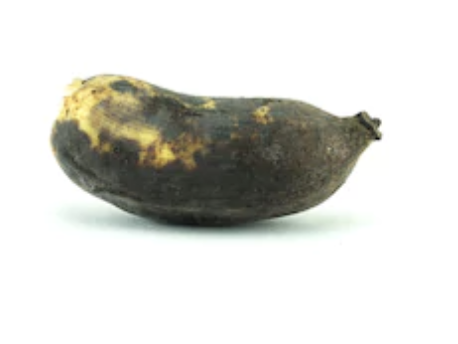

No objects detected for `banana_07.png`

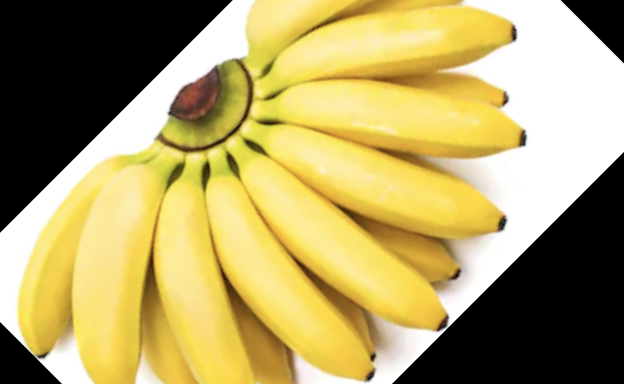

✅ Inference and visualization complete!

In [ ]:
# Inference on validation/sample images and display results
from ultralytics import YOLO
from pathlib import Path
from IPython.display import display, Markdown
from PIL import Image, ImageDraw
import cv2
import numpy as np
import glob

# 1) Locate best weights from training
best_weights = None
try:
    # Most reliable (available right after model.train)
    best_weights = Path(model.trainer.best)
except Exception:
    try:
        best_weights = Path(results.save_dir) / 'weights' / 'best.pt'
    except Exception:
        # Fallback to conventional runs/ directory structure
        best_weights = Path('runs/segment/banana_segmentation') / 'yolov8n_frozen_head' / 'weights' / 'best.pt'


if best_weights and best_weights.exists():
    infer_model = YOLO(str(best_weights))
    display(Markdown(f"✅ Using best weights: `{best_weights}`"))
else:
    # Fall back to the current model in memory
    infer_model = model
    display(Markdown("⚠️ Could not find best.pt on disk. Using the in-memory model for inference."))


# 2) Collect a few images to run inference on (prefer validation images; else sample_images)
candidates = []
val_dir = Path('yolo_banana_dataset/images/val') # Corrected path
sample_dir = Path('sample_images')

if val_dir.exists():
    candidates = list(val_dir.glob('*'))
if not candidates and sample_dir.exists():
    candidates = list(sample_dir.glob('*'))

test_images = [p for p in candidates if p.suffix.lower() in {'.jpg', '.jpeg', '.png'}][:6]
if not test_images:
    raise FileNotFoundError("No test images found in 'yolo_banana_dataset/images/val' or 'sample_images'.")

# 3) Run inference and process results manually
display(Markdown(f"### 📸 Running inference and visualizing results manually..."))

shown = 0
for img_path in test_images:
    try:
        # Run inference on a single image
        preds = infer_model.predict(source=str(img_path), imgsz=640, conf=0.25, save=False, verbose=False)

        # Load the original image
        original_img = cv2.imread(str(img_path))
        if original_img is None:
            print(f"Could not load image: {img_path}")
            continue

        # Draw predictions on the image
        # Ultralytics results object contains boxes and masks
        if preds and preds[0].masks is not None:
            # Convert BGR to RGB for PIL display if needed later, or keep BGR for CV2 drawing
            display_img = original_img.copy() # Work on a copy

            for i, mask in enumerate(preds[0].masks.xy):
                # mask is a numpy array of points [[x1, y1], [x2, y2], ...]
                polygon = mask.astype(np.int32)
                # Get class ID and confidence
                class_id = int(preds[0].boxes.cls[i])
                confidence = float(preds[0].boxes.conf[i])
                class_name = infer_model.names[class_id]

                # Define color based on class (e.g., green for Unripe, yellow for Ripe)
                color = (0, 255, 0) if class_name == "Unripe Banana" else (0, 255, 255) # BGR format (Green, Yellow)

                # Draw the polygon mask
                cv2.fillPoly(display_img, [polygon], color)
                # Optional: add transparency
                alpha = 0.4
                cv2.addWeighted(display_img, alpha, original_img, 1 - alpha, 0, display_img)

                # Draw polygon outline
                cv2.polylines(display_img, [polygon], isClosed=True, color=(255, 255, 255), thickness=2) # White outline

                # Add label and confidence
                label = f'{class_name} {confidence:.2f}'
                (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                # Find top-left point of the polygon to place text
                x, y = polygon[0] # Use the first point of the polygon
                cv2.rectangle(display_img, (x, y - text_height - baseline), (x + text_width, y), color, -1)
                cv2.putText(display_img, label, (x, y - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1) # Black text

            # Convert back to RGB for PIL display
            display_img_rgb = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(display_img_rgb)
            display(pil_img)
            shown += 1

        else:
             display(Markdown(f"No objects detected for `{img_path.name}`"))
             # Display the original image if no predictions were made, to show the image was processed
             original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
             pil_img = Image.fromarray(original_img_rgb)
             display(pil_img)
             shown += 1 # Count the original image as shown


        if shown >= 6:
            break

    except Exception as e:
        print(f"Could not process and display inference for image {img_path}: {e}")
        import traceback
        traceback.print_exc()
        shown += 1 # Still count this towards the shown limit even if it failed to display

if shown == 0:
     display(Markdown(f"⚠️ No test images were processed for inference."))


display(Markdown("✅ Inference and visualization complete!"))